In [1]:
import pandas as pd
import pm4py
import numpy as np
from collections import defaultdict


from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

import copy

In [2]:
#Upload the Wabo data set

log = pm4py.read.read_xes("wabo_all.xes")
log

C:\Users\la1949\Anaconda3\envs\pm4py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 4348/4348 [00:52<00:00, 82.08it/s] 


,taskForMainCase,monitoringResource,org:resource,question,concept:name,dateFinished,action_code,taskName,planned,lifecycle:transition,...,case:last_phase,case:startDate,case:requestComplete,case:SUMleges,case:IDofConceptCase,case:termName,case:landRegisterID,dueDate,dateStop,case:endDatePlanned
0,True,4634935,560530,EMPTY,01_HOOFD_010,2013-01-10 12:07:35+00:00,01_HOOFD_010,Registratie datum binnenkomst aanvraag,2012-03-23 09:21:14+00:00,complete,...,Zaak afgehandeld,2012-03-20 23:00:00+00:00,FALSE,NaN,NaN,NaN,NaN,NaT,NaT,NaT
1,True,4634935,560530,"{'value': 'False', 'children': {'question_code...",01_HOOFD_011,2013-01-10 12:07:35+00:00,01_HOOFD_011,OLO Berichtenverkeer actief,2012-03-23 09:26:05+00:00,complete,...,Zaak afgehandeld,2012-03-20 23:00:00+00:00,FALSE,NaN,NaN,NaN,NaN,NaT,NaT,NaT
2,True,4634935,560530,"{'value': 'True', 'children': {'question_code'...",01_HOOFD_020,2013-01-10 12:07:35+00:00,01_HOOFD_020,Bevestiging ontvangst versturen,NaT,complete,...,Zaak afgehandeld,2012-03-20 23:00:00+00:00,FALSE,NaN,NaN,NaN,NaN,NaT,NaT,NaT
3,True,4634935,560530,EMPTY,01_HOOFD_015,2013-01-10 12:07:35+00:00,01_HOOFD_015,Fase Aanvraag ontvangen,NaT,complete,...,Zaak afgehandeld,2012-03-20 23:00:00+00:00,FALSE,NaN,NaN,NaN,NaN,NaT,NaT,NaT
4,True,4634935,560530,"{'value': 'True', 'children': {'question_code'...",03_GBH_005,2013-01-10 12:07:35+00:00,03_GBH_005,Aanvrager is belanghebbende,NaT,complete,...,Zaak afgehandeld,2012-03-20 23:00:00+00:00,FALSE,NaN,NaN,NaN,NaN,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195857,True,560852,560752,"{'value': 'False', 'children': {'question_code...",01_HOOFD_180,2013-12-30 00:00:00+00:00,01_HOOFD_180,Procedure verandering,2013-12-31 09:04:00+00:00,complete,...,Aanvraag ontvangen,2013-12-26 23:00:00+00:00,TRUE,NaN,8579077,Termijn tot besluit,NaN,NaT,NaT,NaT
195858,True,560852,560752,EMPTY,01_HOOFD_061,2013-12-30 00:00:00+00:00,01_HOOFD_061,Waboprocedure instellen,2013-12-31 09:02:30+00:00,complete,...,Aanvraag ontvangen,2013-12-26 23:00:00+00:00,TRUE,NaN,8579077,Termijn tot besluit,NaN,NaT,NaT,NaT
195859,True,560852,560752,EMPTY,01_HOOFD_015,2013-12-30 00:00:00+00:00,01_HOOFD_015,Fase Aanvraag ontvangen,2013-12-31 09:02:10+00:00,complete,...,Aanvraag ontvangen,2013-12-26 23:00:00+00:00,TRUE,NaN,8579077,Termijn tot besluit,NaN,2014-01-02 09:02:10+00:00,NaT,NaT
195860,True,560852,560752,EMPTY,01_HOOFD_065_1,2013-12-30 00:00:00+00:00,01_HOOFD_065_1,Procedure bevestiging versturen,2013-12-31 09:02:33+00:00,complete,...,Aanvraag ontvangen,2013-12-26 23:00:00+00:00,TRUE,NaN,8579077,Termijn tot besluit,NaN,NaT,NaT,NaT


In [3]:
#Make selection of relevant columns
log_select = log[['case:concept:name', 'time:timestamp', 'taskName', 'case:sublog', 'org:resource']]
log_select

,case:concept:name,time:timestamp,taskName,case:sublog,org:resource
0,10358444,2012-03-20 23:00:00+00:00,Registratie datum binnenkomst aanvraag,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530
1,10358444,2012-03-22 09:26:08+00:00,OLO Berichtenverkeer actief,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530
2,10358444,2012-03-22 09:26:08+00:00,Bevestiging ontvangst versturen,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530
3,10358444,2012-03-22 09:26:08+00:00,Fase Aanvraag ontvangen,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530
4,10358444,2012-03-22 09:26:09+00:00,Aanvrager is belanghebbende,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530
...,...,...,...,...,...
195857,8579071,2013-12-29 23:00:00+00:00,Procedure verandering,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752
195858,8579071,2013-12-29 23:00:00+00:00,Waboprocedure instellen,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752
195859,8579071,2013-12-29 23:00:00+00:00,Fase Aanvraag ontvangen,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752
195860,8579071,2013-12-29 23:00:00+00:00,Procedure bevestiging versturen,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752


## Descriptive Statistics

In [4]:
#Generate Overview - #cases, activities, resources
log_select.nunique()

case:concept:name      4346
time:timestamp       101087
taskName                465
case:sublog               5
org:resource             60
dtype: int64

In [6]:
#Create traces based on event log

# Initialize LabelEncoder - to encode activities
le = LabelEncoder()

# Encode the 'taskName' column
log_select['concept:name'] = le.fit_transform(log_select['taskName'])
log_select

C:\Users\la1949\AppData\Local\Temp\ipykernel_10244\846341865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_select['concept:name'] = le.fit_transform(log_select['taskName'])


,case:concept:name,time:timestamp,taskName,case:sublog,org:resource,concept:name
0,10358444,2012-03-20 23:00:00+00:00,Registratie datum binnenkomst aanvraag,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530,338
1,10358444,2012-03-22 09:26:08+00:00,OLO Berichtenverkeer actief,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530,296
2,10358444,2012-03-22 09:26:08+00:00,Bevestiging ontvangst versturen,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530,93
3,10358444,2012-03-22 09:26:08+00:00,Fase Aanvraag ontvangen,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530,158
4,10358444,2012-03-22 09:26:09+00:00,Aanvrager is belanghebbende,/usr/share/eventlogs/12688511/CoSeLoG WABO 2.xes,560530,21
...,...,...,...,...,...,...
195857,8579071,2013-12-29 23:00:00+00:00,Procedure verandering,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752,319
195858,8579071,2013-12-29 23:00:00+00:00,Waboprocedure instellen,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752,431
195859,8579071,2013-12-29 23:00:00+00:00,Fase Aanvraag ontvangen,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752,158
195860,8579071,2013-12-29 23:00:00+00:00,Procedure bevestiging versturen,/usr/share/eventlogs/12718076/CoSeLoG WABO 4.xes,560752,316


In [7]:
#Generate Trace Log
trace_log = log_select.groupby(['case:concept:name'])['concept:name'].apply(list).reset_index()
trace_log

,case:concept:name,concept:name
0,10358444,"[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,..."
1,11269753,"[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,..."
2,11666570,"[338, 277, 271, 221, 256, 358, 225, 260, 343, ..."
3,12421232,"[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,..."
4,12592056,"[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,..."
...,...,...
4341,9987434,"[338, 296, 93, 21, 426, 425, 153, 376, 322, 40..."
4342,9988302,"[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]"
4343,9989988,"[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]"
4344,9990823,"[338, 296, 93, 21, 426, 425, 153, 376, 322, 40..."


In [8]:
##### NEW
#Derive set of unique trace variants + count
logVar = trace_log
logVar["act_str"] = logVar["concept:name"].apply(lambda x: str(x))
logVar['Count'] = logVar.groupby(['act_str'])['concept:name'].transform('count')
logVar = logVar.drop_duplicates(subset=['act_str'], keep='first')
logVar = logVar.reset_index(drop=True)
logVar

,case:concept:name,concept:name,act_str,Count
0,10358444,"[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,...","[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,...",1
1,11269753,"[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,...","[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,...",1
2,11666570,"[338, 277, 271, 221, 256, 358, 225, 260, 343, ...","[338, 277, 271, 221, 256, 358, 225, 260, 343, ...",1
3,12421232,"[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,...","[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,...",1
4,12592056,"[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,...","[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,...",1
...,...,...,...,...
4240,9979764,"[338, 296, 93, 21, 426, 425, 158]","[338, 296, 93, 21, 426, 425, 158]",1
4241,9980907,"[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]","[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]",3
4242,9989988,"[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]","[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]",1
4243,9990823,"[338, 296, 93, 21, 426, 425, 153, 376, 322, 40...","[338, 296, 93, 21, 426, 425, 153, 376, 322, 40...",1


In [9]:
#Distribution of Frequencies
logVar.groupby(logVar['Count'].tolist(),as_index=False).size()

,index,size
0,1,4201
1,2,29
2,3,4
3,4,5
4,5,1
5,6,1
6,7,1
7,9,1
8,10,1
9,18,1


In [1]:
#Percentage of Trace Variants occuring only once
4201/4245

0.9896348645465253

In [10]:
#Calculate length of traces
logVar["trace_length"] = logVar["concept:name"].apply(lambda x: len(x))
print(logVar.trace_length.min(), logVar.trace_length.max())

1 124


In [11]:
#Number of activity types
act = list(set([a for b in logVar['concept:name'].tolist() for a in b]))
len(act)

465

In [12]:
logVar["c:n_chr"] = logVar["concept:name"].apply(lambda x: [chr(int(i)) for i in x])
logVar["strings"] = logVar["c:n_chr"].apply(lambda x: ''.join(x))
logVar

,case:concept:name,concept:name,act_str,Count,trace_length,c:n_chr,strings
0,10358444,"[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,...","[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,...",1,84,"[Œ, Ĩ, ], , , &, Ď, Ɣ, , $, Ÿ, ĝ, , Ê, ļ, ...","ŒĨ]&ĎƔ$ŸĝÊļĕŐƸ9ĿƁĔĺŵhƹŀ""Ôƺ¤Ï±İǎ..."
1,11269753,"[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,...","[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,...",1,79,"[Œ, Ĩ, ], , &, , Ɣ, Ď, , $, Ÿ, ĝ, , Ê, ļ, ...","ŒĨ]&ƔĎ$ŸĝÊļĕŐƂƓŔƸ9Ŀhƹŀ""ƺÔ¤Ïŭ±İ¶·ŏ Ē..."
2,11666570,"[338, 277, 271, 221, 256, 358, 225, 260, 343, ...","[338, 277, 271, 221, 256, 358, 225, 260, 343, ...",1,60,"[Œ, ĕ, ď, Ý, Ā, Ŧ, á, Ą, ŗ, Þ, Ĩ, ], , Ʃ, , ...","ŒĕďÝĀŦáĄŗÞĨ]ƩƔŸƯłļĿņhŁ""ƺ<¤ÔsƊ UóÌQ¦Ŝ..."
3,12421232,"[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,...","[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,...",1,40,"[Œ, Ĩ, ], , &, , Ď, Ɣ, , $, Ÿ, ĕ, ļ, Ƃ, Ɠ, ...","ŒĨ]&ĎƔ$ŸĕļƂƓŔ9ĿhĦŀ""ƺ<ƊÔ ¤ÌťÇ ĄÐ"
4,12592056,"[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,...","[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,...",1,43,"[Œ, Ĩ, , ], , &, , Ď, Ɣ, , $, Ÿ, ļ, ĕ, Ɠ, ...","ŒĨ]&ĎƔ$ŸļĕƓŔ9ĿhB>ŀ""Ôƺ<Ɗ¤H ÌťÇF ĄÐ"
...,...,...,...,...,...,...,...
4240,9979764,"[338, 296, 93, 21, 426, 425, 158]","[338, 296, 93, 21, 426, 425, 158]",1,7,"[Œ, Ĩ, ], , ƪ, Ʃ, ]",ŒĨ]ƪƩ
4241,9980907,"[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]","[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]",3,10,"[Œ, Ĩ, ], , ƪ, Ʃ, , Ɣ, , ď]",ŒĨ]ƪƩƔď
4242,9989988,"[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]","[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]",1,10,"[Ĩ, ], , ƪ, Ʃ, , , Œ, Ɣ, ď]",Ĩ]ƪƩŒƔď
4243,9990823,"[338, 296, 93, 21, 426, 425, 153, 376, 322, 40...","[338, 296, 93, 21, 426, 425, 153, 376, 322, 40...",1,38,"[Œ, Ĩ, ], , ƪ, Ʃ, , Ÿ, ł, Ɣ, , Ư, ď, Ŀ, , ...","ŒĨ]ƪƩŸłƔƯďĿhŁ""ƺ<sƊUQƏó9Ì¤Ô¦"


## Derive Variety Values

In [13]:
#Calculate Levenshtein Distance
from Levenshtein import distance

#Calculate linkage Matrix
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

#Distances after clustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import squareform

#For Evaluation
from scipy.integrate import simpson
from numpy import trapz
import scipy.stats

In [14]:
#Calculate distance matrix based on Normalized Levenshtein Distance
def Lev(logVar):
    
    List = logVar["strings"]

    n = len(List)
    dist_matrix = np.zeros((n,n))    # initialize distance matrix to a square of zeros

    for i in range(n):
        for j in range(i, n):
            dist_matrix[i,j] = distance(List[i], List[j])
            dist_matrix[j,i] = dist_matrix[i,j]       # for the symmetric part, no computation

    return dist_matrix

In [15]:
lev_dis = Lev(logVar)
lev_dis

array([[ 0., 51., 77., ..., 80., 71., 81.],
       [51.,  0., 71., ..., 75., 66., 76.],
       [77., 71.,  0., ..., 56., 43., 55.],
       ...,
       [80., 75., 56., ...,  0., 30., 10.],
       [71., 66., 43., ..., 30.,  0., 33.],
       [81., 76., 55., ..., 10., 33.,  0.]])

In [21]:
#Calculate overall Variety based on Minimum Spanning Tree
def mst(linkage_matrix):
    x = 0
    for i in linkage_matrix:
        x += i[2]
    return x

#logVariety = mst(linkage_matrix)
#logVariety

In [22]:
#Derive ordering of traces based on their marginal distance

def marginal_variety(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(len(pairwise_distances)-1):
        # Find the minimum value and its indices
        min_val = np.nanmin(modified_distances)  # Use np.nanmin to ignore NaN values
        min_indices = np.argwhere(modified_distances == min_val)
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = min_indices[0][0], min_indices[0][0]
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)
        margVariety.append(min_val)
        
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
    #return modified_distances
    return traceOrder, margVariety #modified_distances


#order, margVar = marginal_variety(cophenet_matrix)
#margVar

In [23]:
#Create ordered list of Alignment costs

def marginal_alignments(pairwise_distances, order):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    modified_distances = abs(modified_distances)
    #traceOrder = []
    margAlignments = []
    
    removed = []
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate over ordered list of trace variants to be removed
    for i in order:
        #Add i to list of removed TraceVar
        removed.append(i)
        alignmentCost = 0
        
        #Change values in the column corresponding to i to NaN
        modified_distances[:, i] = np.nan
        
        #Iterate over list of removed trace variants to derive alignment costs
        for i in removed:
            
            # Find the minimum value and its indices
            min_val = np.nanmin(modified_distances[i])  # Use np.nanmin to ignore NaN values
            
            #Add value to alignment cost
            alignmentCost += min_val
 
        #Add alignment cost to list
        margAlignments.append(alignmentCost)
        
        
    #return modified_distances
    return margAlignments #modified_distances



#margAlignCosts = marginal_alignments(Matrix_Align, order)
#margAlignCosts

In [24]:
#Calculate increase in alignment costs
def alignIncrease(margAlignCosts):
    inAlign = [0]
    newAlign = 0
    for i in margAlignCosts:
        newAlign += i
        inAlign.append(newAlign)
    return inAlign

#alignCostIncrease = alignIncrease(margAlignCosts)

In [25]:
#Calculate decrease in variety
def varDecrease(var, margVar):
    deVar = [var]
    newVar = var
    for i in margVar:
        newVar -= i
        deVar.append(newVar)
    return deVar

#varietyDecrease = varDecrease(logVariety, margVar)

## Based on Levenshtein Distance

In [38]:
from scipy.spatial.distance import squareform

# Convert the square distance matrix to a condensed distance matrix
condensed_lev_dis = squareform(lev_dis)
condensed_lev_dis

array([51., 77., 60., ..., 30., 10., 33.])

In [51]:
from scipy.spatial.distance import squareform

def varAlignCosts(Matrix_Align):
    
    #Calculate linkage Matrix
    condensed_Matrix_Align = squareform(Matrix_Align)
    linkage_matrix = linkage(condensed_Matrix_Align, "centroid")

    #Calculate overall Variety based on Minimum Spanning Tree
    logVariety = mst(linkage_matrix)
    #print('Overall variety:', logVariety)

    #Distances after clustering
    cophenet_matrix = squareform(cophenet(linkage_matrix))

    #Derive ordering of traces based on their marginal distance
    order, margVar = marginal_variety(cophenet_matrix)
    #margVar

    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    #margAlignCosts

    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)
        
    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(cophenet_matrix)))
    y = varietyDecrease
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    #print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    #print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

    #Evaluate Clustering
    #from scipy.cluster.hierarchy import fcluster
    labels = fcluster(linkage_matrix, t=len(logVar)/2, criterion='maxclust')
    silhoutte = metrics.silhouette_score(abs(Matrix_Align), labels, metric="precomputed")
    print("silhouette_value", silhoutte)

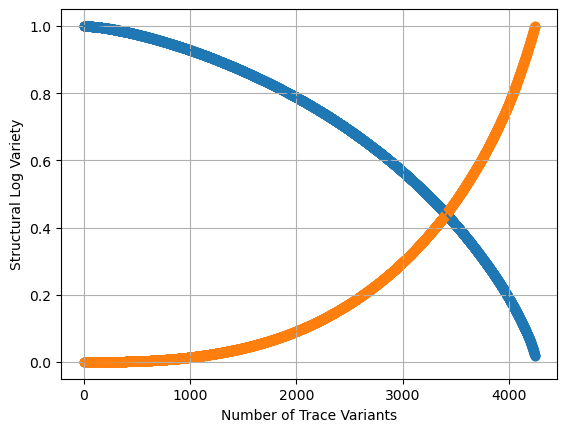

intersection: [3407]
area_trapeziodal: 941.4364198657886
area_Simpson: 941.4363239613555
Pearson's r: PearsonRResult(statistic=-0.9837871521769632, pvalue=0.0)
silhouette_value -0.013997976747782666


In [50]:
#centroid linkage
varAlignCosts(lev_dis)

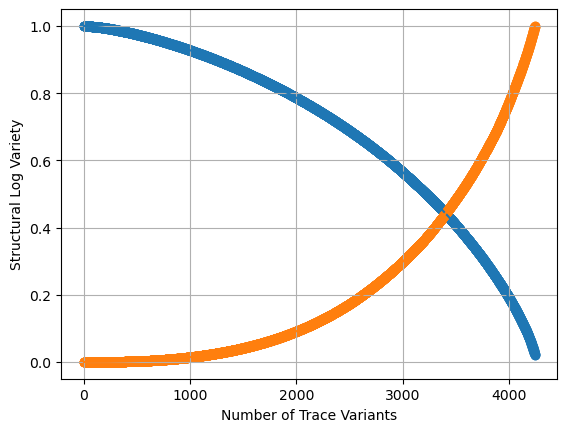

intersection: [3403]
area_trapeziodal: 943.7807545657148
area_Simpson: 943.7806606314105
Pearson's r: PearsonRResult(statistic=-0.9833441730670094, pvalue=0.0)
silhouette_value -0.012623040986451657


In [52]:
#median linkage
varAlignCosts(lev_dis)

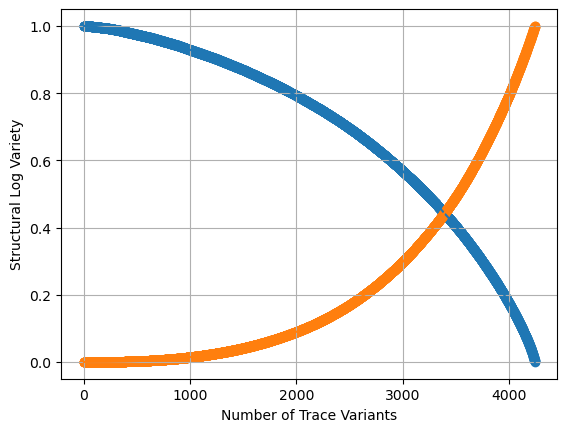

intersection: [3392]
area_trapeziodal: 954.9445294322034
area_Simpson: 954.9444502693397
Pearson's r: PearsonRResult(statistic=-0.9851824868503873, pvalue=0.0)
silhouette_value -0.11649564702972139


In [48]:
#single linkage
varAlignCosts(lev_dis)

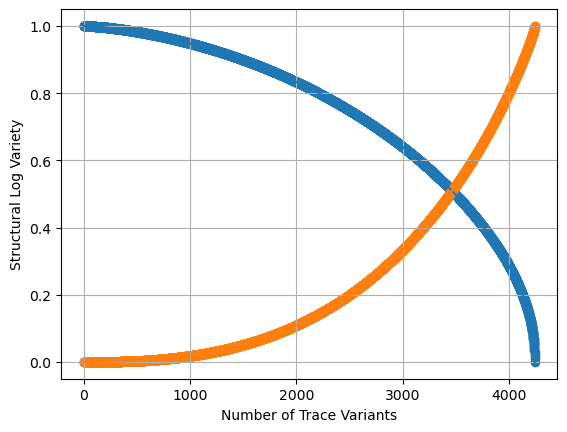

intersection: [3464]
area_trapeziodal: 1024.3063668339973
area_Simpson: 1024.306234059377
Pearson's r: PearsonRResult(statistic=-0.9945526466945661, pvalue=0.0)
silhouette_value 0.11629700642259908


In [46]:
#ward linkage
varAlignCosts(lev_dis)

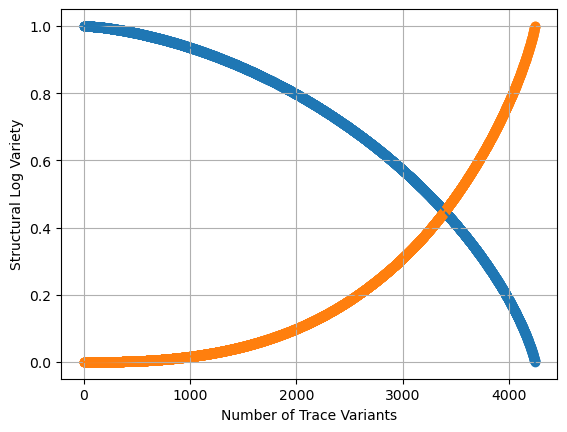

intersection: [3392]
area_trapeziodal: 967.8066538907714
area_Simpson: 967.8065456681218
Pearson's r: PearsonRResult(statistic=-0.9888354786967246, pvalue=0.0)
silhouette_value 0.0949978374438503


In [42]:
#complete linkage
varAlignCosts(lev_dis)

## Baseline Relative Frequency

In [18]:
logVar['index'] = logVar.index
logVar

,case:concept:name,concept:name,act_str,Count,trace_length,c:n_chr,strings,index
0,10358444,"[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,...","[338, 296, 93, 158, 21, 38, 270, 404, 153, 36,...",1,84,"[Œ, Ĩ, ], , , &, Ď, Ɣ, , $, Ÿ, ĝ, , Ê, ļ, ...","ŒĨ]&ĎƔ$ŸĝÊļĕŐƸ9ĿƁĔĺŵhƹŀ""Ôƺ¤Ï±İǎ...",0
1,11269753,"[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,...","[338, 296, 93, 21, 38, 158, 404, 270, 153, 36,...",1,79,"[Œ, Ĩ, ], , &, , Ɣ, Ď, , $, Ÿ, ĝ, , Ê, ļ, ...","ŒĨ]&ƔĎ$ŸĝÊļĕŐƂƓŔƸ9Ŀhƹŀ""ƺÔ¤Ïŭ±İ¶·ŏ Ē...",1
2,11666570,"[338, 277, 271, 221, 256, 358, 225, 260, 343, ...","[338, 277, 271, 221, 256, 358, 225, 260, 343, ...",1,60,"[Œ, ĕ, ď, Ý, Ā, Ŧ, á, Ą, ŗ, Þ, Ĩ, ], , Ʃ, , ...","ŒĕďÝĀŦáĄŗÞĨ]ƩƔŸƯłļĿņhŁ""ƺ<¤ÔsƊ UóÌQ¦Ŝ...",2
3,12421232,"[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,...","[338, 296, 93, 21, 38, 158, 270, 404, 153, 36,...",1,40,"[Œ, Ĩ, ], , &, , Ď, Ɣ, , $, Ÿ, ĕ, ļ, Ƃ, Ɠ, ...","ŒĨ]&ĎƔ$ŸĕļƂƓŔ9ĿhĦŀ""ƺ<ƊÔ ¤ÌťÇ ĄÐ",3
4,12592056,"[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,...","[338, 296, 19, 93, 21, 38, 158, 270, 404, 153,...",1,43,"[Œ, Ĩ, , ], , &, , Ď, Ɣ, , $, Ÿ, ļ, ĕ, Ɠ, ...","ŒĨ]&ĎƔ$ŸļĕƓŔ9ĿhB>ŀ""Ôƺ<Ɗ¤H ÌťÇF ĄÐ",4
...,...,...,...,...,...,...,...,...
4240,9979764,"[338, 296, 93, 21, 426, 425, 158]","[338, 296, 93, 21, 426, 425, 158]",1,7,"[Œ, Ĩ, ], , ƪ, Ʃ, ]",ŒĨ]ƪƩ,4240
4241,9980907,"[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]","[338, 296, 93, 21, 426, 425, 153, 404, 158, 271]",3,10,"[Œ, Ĩ, ], , ƪ, Ʃ, , Ɣ, , ď]",ŒĨ]ƪƩƔď,4241
4242,9989988,"[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]","[296, 93, 21, 426, 425, 153, 158, 338, 404, 271]",1,10,"[Ĩ, ], , ƪ, Ʃ, , , Œ, Ɣ, ď]",Ĩ]ƪƩŒƔď,4242
4243,9990823,"[338, 296, 93, 21, 426, 425, 153, 376, 322, 40...","[338, 296, 93, 21, 426, 425, 153, 376, 322, 40...",1,38,"[Œ, Ĩ, ], , ƪ, Ʃ, , Ÿ, ł, Ɣ, , Ư, ď, Ŀ, , ...","ŒĨ]ƪƩŸłƔƯďĿhŁ""ƺ<sƊUQƏó9Ì¤Ô¦",4243


In [28]:
logVar_sort = logVar.sort_values(by=['Count'])
frequRank = logVar_sort['index'].to_list()
print(frequRank)

[0, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2814, 2844, 2813, 2811, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2812, 2781, 2845, 2847, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2880, 2846, 2879, 2877, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2878, 2910, 2780, 2777, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2681, 2711, 2680, 2678, 2649, 

In [33]:
#Derive ordering of traces based on frequencies
import math

def marginal_variety_baseline(pairwise_distances,frequency_list):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    totalVariety = []
    del frequency_list[-1]
    #numbVar = len(pairwise_distances)
    #remaining = list(range(0,numbVar))
    
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    #for i in range(numbVar-1):
    for i in frequency_list:
        
        #Select random variant to be removed
        #indices = np.random.choice(remaining)
        indices = i
        #remaining.remove(indices)
        min_val = np.nanmin(modified_distances[indices])
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = indices, indices
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)        
        margVariety.append(min_val)
        
        #Calculate variety based on distances of remaining traces 
        variety = 0
        for i in modified_distances:
            if math.isnan(np.nanmin(i)):
                continue
            variety += np.nanmin(i)
        totalVariety.append(variety)
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
    
    return traceOrder, margVariety, totalVariety #modified_distances
    

In [34]:
order, margVar, totalVar = marginal_variety_baseline(lev_dis,frequRank)

C:\Users\la1949\AppData\Local\Temp\ipykernel_10244\337301411.py:39: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


In [36]:
def varAlignCosts2(Matrix_Align,frequency_list,order,margVar,totalVar):
    
    #order, margVar, totalVar = marginal_variety_baseline(Matrix_Align,frequency_list)
    totalVar.append(0)
    
    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    
    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)
    
    
    #Calculate overall Variety based on sum of margVar
    logVariety = sum(margVar)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)


    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(Matrix_Align)))
    y = totalVar
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)
    
    #Monotonicity trend
    diffs = np.diff(totalVar)
    monoRate = np.sum(diffs >= 0) / (len(totalVar)-2)
    print("monotonViolation:", monoRate)
    print("equality:", np.sum(diffs == 0))
    print("increase:", np.sum(diffs > 0))


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 

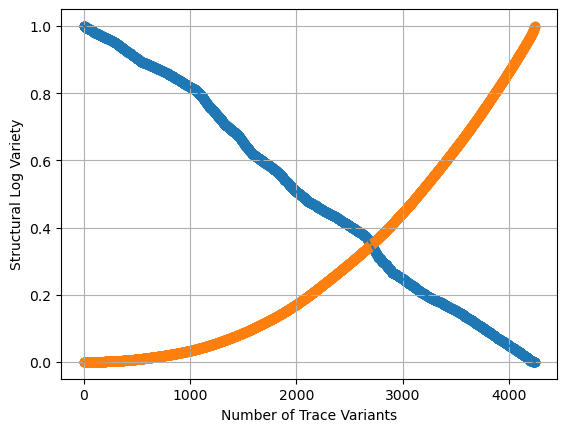

intersection: [2699]
area_trapeziodal: 1269.2304002054307
area_Simpson: 1269.2303192271086
monotonViolation: 0.07094037237803441
equality: 103
increase: 198
Pearson's r: PearsonRResult(statistic=-0.9437767174123217, pvalue=0.0)
Spearman's rho: SignificanceResult(statistic=-0.9999999377606392, pvalue=0.0)
Kendall's tau: SignificanceResult(statistic=-0.9999350009803283, pvalue=0.0)


In [37]:
varAlignCosts2(lev_dis,frequRank,order,margVar,totalVar)

## Baseline Random Selection

In [19]:
#Derive ordering of traces based on random selection
import math

def marginal_variety_baseline(pairwise_distances):
    # Create a copy of the pairwise distance matrix
    modified_distances = pairwise_distances.astype(float)
    traceOrder = []
    margVariety = []
    totalVariety = []
    numbVar = len(pairwise_distances)
    remaining = list(range(0,numbVar))
    
    
    
    # Set diagonal elements to NaN
    np.fill_diagonal(modified_distances, np.nan)
    
    # Iterate to remove the desired number of minimum values
    for i in range(numbVar-1):
        
        #Select random variant to be removed
        indices = np.random.choice(remaining)
        remaining.remove(indices)
        min_val = np.nanmin(modified_distances[indices])
        
        # Get the row and column indices to replace by NaN
        row_idx, col_idx = indices, indices
        
        #Get order of traces + their marginal contribution to variety
        traceOrder.append(row_idx)        
        margVariety.append(min_val)
        
        #Calculate variety based on distances of remaining traces 
        variety = 0
        for i in modified_distances:
            if math.isnan(np.nanmin(i)):
                continue
            variety += np.nanmin(i)
        totalVariety.append(variety)
        
        # Change values in the row and column corresponding to the minimum value to NaN
        modified_distances[row_idx, :] = np.nan
        modified_distances[:, col_idx] = np.nan
        
        
    #return modified_distances
    return traceOrder, margVariety, totalVariety #modified_distances

In [20]:
def varAlignCosts2(Matrix_Align):
    
    order, margVar, totalVar = marginal_variety_baseline(Matrix_Align)
    totalVar.append(0)
    
    #Create ordered list of Alignment costs
    margAlignCosts = marginal_alignments(Matrix_Align, order)
    
    #Calculate increase in alignment costs
    alignCostIncrease = alignIncrease(margAlignCosts)
    
    
    #Calculate overall Variety based on sum of margVar
    logVariety = sum(margVar)

    #Calculate decrease in variety
    varietyDecrease = varDecrease(logVariety, margVar)


    #Plot Variety and Alginment Costs

    # Label für die y-Achse vergeben:
    plt.ylabel('Structural Log Variety')
    plt.xlabel('Number of Trace Variants')


    x = list(range(0, len(Matrix_Align)))
    y = totalVar
    y = y / max(y) #normalization

    y2 = alignCostIncrease
    y2 = y2 / max(y2) #normalization

    # Einen x-y-Plot erstellen:
    plt.plot(x, y)
    plt.plot(x, y2)

    # plot scatter plot with x and y data 
    plt.scatter(x, y)
    plt.scatter(x, y2)

    # Achsen-Bereiche manuell festlegen
    # Syntax: plt.axis([xmin, xmax, ymin, ymax])
    #plt.axis([0, 5, 0, 20])

    # Ein gepunktetes Diagramm-Gitter einblenden:
    plt.grid(True)

    # Diagramm anzeigen:
    plt.show()
    
    idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
    print("intersection:", idx)

    # Area under Curve
    #from scipy.integrate import simpson
    #from numpy import trapz
    # Compute the area using the composite trapezoidal rule.
    area = trapz(y2, dx=1)
    print("area_trapeziodal:", area)
    # Compute the area using the composite Simpson's rule.
    area = simpson(y2, dx=1)
    print("area_Simpson:", area)
    
    #Monotonicity trend
    diffs = np.diff(totalVar)
    monoRate = 1 - (np.sum(diffs >= 0) / (len(totalVar)-2))
    print("monotonViolation:", monoRate)
    print("equality:", np.sum(diffs == 0))
    print("increase:", np.sum(diffs > 0))


    #Correlation variety ~ alignment costs
    #import scipy.stats
    #y = varietyDecrease
    #y2 = alignCostIncrease

    print("Pearson's r:", scipy.stats.pearsonr(y, y2))    
    print("Spearman's rho:", scipy.stats.spearmanr(y, y2))   
    print("Kendall's tau:", scipy.stats.kendalltau(y, y2)) 


C:\Users\la1949\AppData\Local\Temp\ipykernel_12840\3781539750.py:36: RuntimeWarning: All-NaN slice encountered
  if math.isnan(np.nanmin(i)):


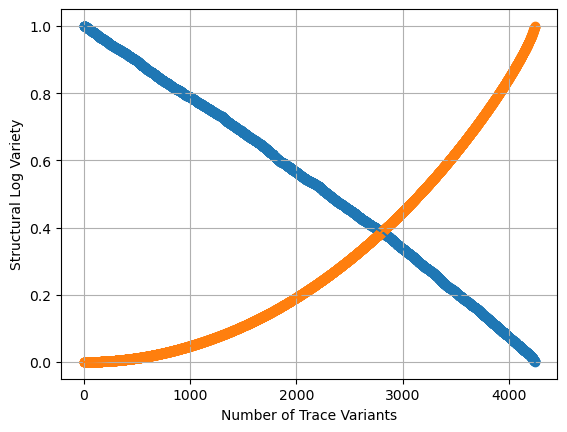

intersection: [2801]
area_trapeziodal: 1290.4702798888493
area_Simpson: 1290.4700603144602
monotonViolation: 0.9290596276219656
equality: 108
increase: 193
Pearson's r: PearsonRResult(statistic=-0.9695097489175565, pvalue=0.0)
Spearman's rho: SignificanceResult(statistic=-0.9999999484672211, pvalue=0.0)
Kendall's tau: SignificanceResult(statistic=-0.9999403296693391, pvalue=0.0)


In [21]:
varAlignCosts2(lev_dis)